In [1]:
# Scoring networks
# Using RBFENN output connected matrix, with SEM predictions (not scaled) to determine total SEM from 
# reference node to each node
# dijkstra algorithm
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.dijkstra.html

# To apply to different networks
Define network_path, name of the "useful" RBFENN network file, and pick and origin node. If origin node should be calculated, set the <code>calculate_origin</code> flag to True

In [2]:
network_path = "../networks/very_large-22-06-28/"
rbfenn_output = f"{network_path}rbfenn_network_output_useful.txt"
origin = None
calculate_origin = True

# Read data
rbfenn_network_output_useful is in form:<br>
node1, node2, idx1, idx2, sem_norm, sem<br>
where:<br>
node1 and node2 are the enumerated indices for each ligand transformation<br>
idx1 and idx2 and the ligand names used in this project, refering to the row in the master df<br>
sem_norm is the normalised SEM value used as input to the LOMAP algorithm<br>
sem is the predicted value of the transformation (not normalised)<br>

In [3]:
#Reading all data
sem_scores = []
row_idx = []
col_idx = []
sem_scores_normalised = []
labeldict = {}

with open (rbfenn_output, "r") as file:
    for line in file.readlines():
        line = line.rstrip()
        line = line.split(" ")
        sem_scores.append(float(line[-1]))
        sem_scores_normalised.append(float(line[-2]))
        row_idx.append(int(line[0]))
        col_idx.append(int(line[1]))
        
        labeldict[int(line[0])] = line[2]
        labeldict[int(line[1])] = line[3]
        
shape = max(max(row_idx), max(col_idx)) + 1

# scipy modules for path finding

In [4]:
from scipy.sparse import csr_matrix
from scipy.sparse import csgraph
from scipy.sparse.csgraph import dijkstra
from scipy.sparse.csgraph import shortest_path

In [5]:
#sparse matrix object
graph = csr_matrix((sem_scores, (row_idx, col_idx)), shape=(shape,shape))

In [6]:
# Define origin node
# LOMAP algorithm defines the origin node, however I have no extracted this information
# Here is assume the origin in the node with most edges
# In practice origin would be the reference ligand
all_nodes_in_graph = (row_idx+col_idx)
counts = []
for i in range(shape):
    counts.append((i,all_nodes_in_graph.count(i)))
best_connected_node = max(counts, key=lambda x: x[1])
worst_connected_node = min(counts, key=lambda x: x[1])
print(f"Best: index: {best_connected_node[0]}, edges: {best_connected_node[1]}")
print(f"Worst: index: {worst_connected_node[0]}, edges: {worst_connected_node[1]}")

Best: index: 52, edges: 29
Worst: index: 12, edges: 1


In [7]:
if calculate_origin:
    origin = best_connected_node[0]
    #origin = worst_connected_node[0]

# Dijkstra's finding shortest path from origin to all other nodes

In [8]:
#Consider sem prediction
dist_matrix, predecessors = shortest_path(csgraph=graph,
                                          directed=False,
                                          indices=origin,
                                          return_predecessors=True,
                                          method="D",
                                          unweighted = False
                                         )

#Only number of edges consider
dist_matrix_unweighted, predecessors_unweighted = shortest_path(csgraph=graph,
                                          directed=False,
                                          indices=origin,
                                          return_predecessors=True,
                                          method="D",
                                          unweighted = True
                                         )

In [9]:
#Algorithm return distance to self as (origin, -9999) which needs to be removed
shortest_path_edges = []
for counter,line in enumerate(predecessors):
    shortest_path_edges.append((counter, line))
shortest_path_edges.remove((origin, -9999))

# Visualisation of network

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [11]:
#By default, origin node has distance = 0, and appears incongruous
#Here we replace the distance of origin node to that of the minimum,
#Making colours looks better
second_smallest = dist_matrix[np.argpartition(dist_matrix, 2)][1]
node_colours = dist_matrix.copy()
node_colours[node_colours == 0. ] = second_smallest

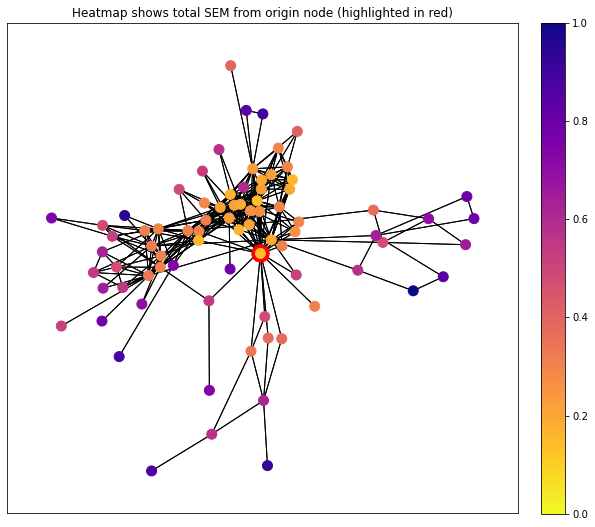

In [12]:
#Define plot, subplot, make square, size
fig = plt.gcf()
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')
fig.set_size_inches(10,10)

#networkX graph object
G = nx.from_scipy_sparse_matrix(graph)

#Defining the shape for visualisation. Seed to make graphs comprable. 
pos = nx.spring_layout(G, seed=4)

#Draw all edges on graph, defined by RBFENN
nx.draw_networkx_edges(G, pos, width=1)

#Highlight edges used in shortest path
#nx.draw_networkx_edges(G, pos, edgelist=shortest_path_edges, width=3, edge_color="r") # draw highlighted edges

#Highlight the origin node
nx.draw_networkx_nodes(G, pos, nodelist=[origin], node_size=300, node_color="r") # Highlight origin node


#variables for heatmap
cmap="plasma_r"
vmin = 0
vmax = 1 #Strictly defining min and max keeps networks comparable
         #vmax = np.amax(node_colours)

#Draw network
nx.draw_networkx(G, pos,
                 node_color=node_colours, cmap=cmap,vmin=vmin, vmax=vmax,
                 labels=labeldict, with_labels=False,
                 node_size=100, node_shape="o")

#Add title
ax.set_title("Heatmap shows total SEM from origin node (highlighted in red)")

#Add colourbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
plt.colorbar(sm,fraction=0.044, pad=0.04)

plt.show()

# Visualise results

In [13]:
import seaborn as sns

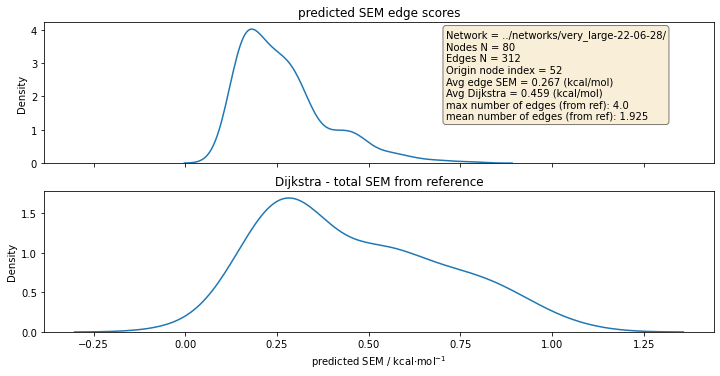

In [14]:
#Stacking two plots, share the x-axis
fig, (ax1,ax2) = plt.subplots(2, figsize=(12, 4), sharex=True) # easier for controlling figure dims

#Super title
#fig.suptitle('Predicted SEM Scores (not normalised)',fontsize=16)

#plot top figure
ax1.set_title("predicted SEM edge scores")
sns.kdeplot(sem_scores, ax=ax1)

#plot lower figure
ax2.set_title("Dijkstra - total SEM from reference")
sns.kdeplot(dist_matrix, ax=ax2)
ax2.set_xlabel("predicted SEM / kcal$\cdot$mol$^{-1}$")

# Yellow box on right
note = f"""Network = {network_path}
Nodes N = {len(dist_matrix)}
Edges N = {len(sem_scores)}
Origin node index = {origin}
Avg edge SEM = {round(sum(sem_scores)/len(sem_scores), 3)} (kcal/mol)
Avg Dijkstra = {round(np.mean(dist_matrix), 3)} (kcal/mol)
max number of edges (from ref): {round(np.amax(dist_matrix_unweighted), 3)}
mean number of edges (from ref): {round(np.mean(dist_matrix_unweighted), 3)}"""

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.6, 0.95, note, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top',
         bbox=props)

#add spacing
plt.subplots_adjust(top=1.2)
plt.show()